# Disparity calculation using Iterative Lucas-Kanade

## Description

Disparity calculation using optical flow registration technique, Iterative Lucas-Kanade [[source](https://scikit-image.org/docs/dev/api/skimage.registration.html#optical-flow-ilk)].

## Setup

**Packages**

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

import pivuq

**Load images**

In [3]:
parent_path = "./data/particledisparity_code_testdata/"
image_pair = np.array(
    [
        plt.imread(os.path.join(parent_path + ipath)).astype("float")
        for ipath in ["B00010.tif", "B00011.tif"]
    ]
)

**Plot raw data**

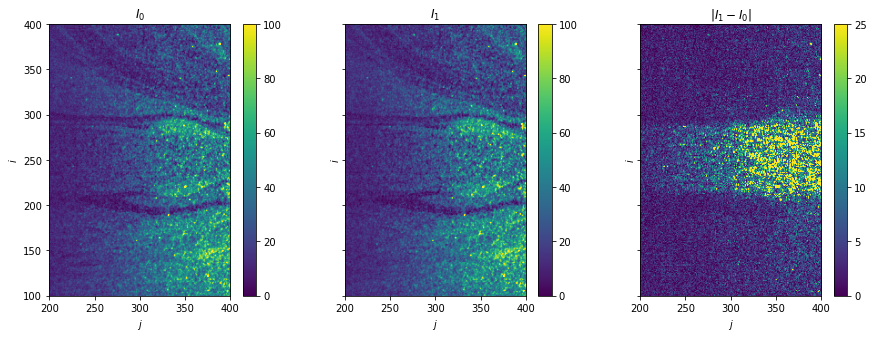

In [4]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 5))

for i, ax in enumerate(axes[:2]):
    im = ax.imshow(image_pair[i], vmax=100)
    fig.colorbar(im, ax=ax)
    ax.set(title=f"$I_{i}$")

ax = axes[-1]
im = ax.imshow(np.abs(image_pair[1] - image_pair[0]), vmin=0, vmax=25)
fig.colorbar(im, ax=ax)
ax.set(title="$|I_1 - I_0|$")

for ax in axes:
    ax.set(xlim=(200, 400), ylim=(100, 400), xlabel="$j$", ylabel="$i$")

**Load reference velocity and disparity**

In [5]:
data = np.loadtxt(os.path.join(parent_path + "B00010_UQ.dat"), skiprows=3).T

I, J = 128, 128
X_ref = np.reshape(data[0], (I, J)) - 1  # zero-index
Y_ref = np.reshape(data[1], (I, J)) - 1
U_ref = np.stack((np.reshape(data[2], (I, J)), np.reshape(data[3], (I, J))))
e_ref = np.stack((np.reshape(data[4], (I, J)), np.reshape(data[5], (I, J))))
N_ref = np.reshape(data[6], (I, J))

window_size = X_ref[0][1] - X_ref[0][0]

**Plot reference velocity and disparity**

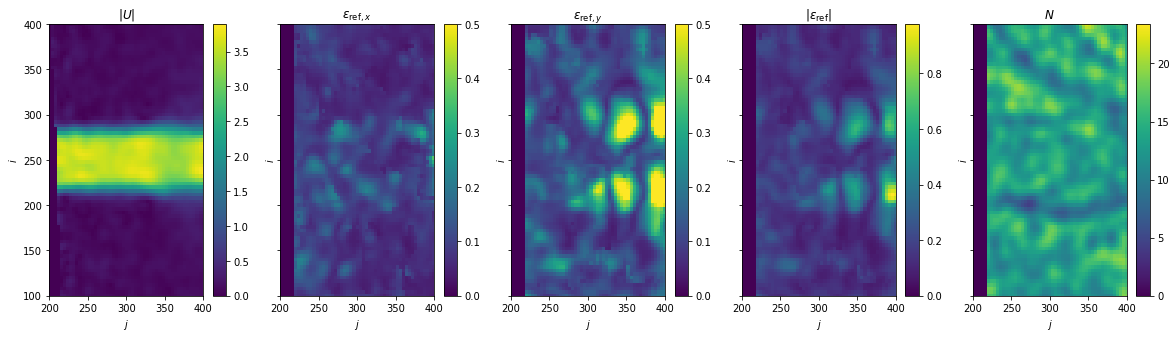

In [6]:
fig, axes = plt.subplots(ncols=5, sharex=True, sharey=True, figsize=(20, 5))

ax = axes[0]
im = ax.pcolormesh(X_ref, Y_ref, np.linalg.norm(U_ref, axis=0))
fig.colorbar(im, ax=ax)
ax.set(title=r"$|U|$")

for i, (ax, var) in enumerate(
    zip(axes[1:4], [r"\epsilon_{\mathrm{ref},x}", r"\epsilon_{\mathrm{ref},y}"])
):
    im = ax.pcolormesh(X_ref, Y_ref, e_ref[i], vmax=0.5)
    fig.colorbar(im, ax=ax)
    ax.set(title=f"${var}$")

ax = axes[3]
im = ax.pcolormesh(X_ref, Y_ref, np.linalg.norm(e_ref, axis=0))
fig.colorbar(im, ax=ax)
ax.set(title=r"$|\epsilon_{\mathrm{ref}}|$")

ax = axes[4]
im = ax.pcolormesh(X_ref, Y_ref, N_ref)
fig.colorbar(im, ax=ax)
ax.set(title=r"$N$")

for ax in axes.ravel():
    ax.set(xlim=(200, 400), ylim=(100, 400), xlabel="$j$", ylabel="$i$")

## Disparity calculation

In [7]:
%%time
X, Y, e = pivuq.disparity.ilk(
    image_pair,
    U_ref,
    window_size=16,
    window="gaussian",
    velocity_upsample_kind="linear",
    warp_direction="center",
    warp_order=1,
    warp_nsteps=1,
)

CPU times: user 2.31 s, sys: 50 ms, total: 2.36 s
Wall time: 2.37 s


## Plot: Disparity map - Reference vs. ILK

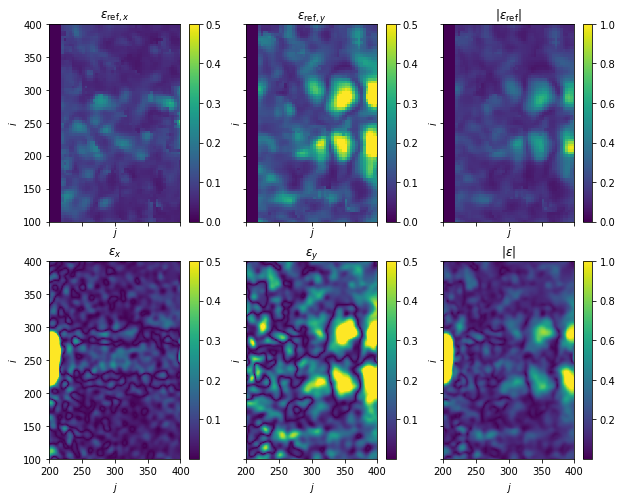

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10, 8))

for i, (ax, var) in enumerate(
    zip(axes[0, :3], [r"\epsilon_{\mathrm{ref},x}", r"\epsilon_{\mathrm{ref},y}"])
):
    im = ax.pcolormesh(X_ref, Y_ref, e_ref[i], vmax=0.5)
    fig.colorbar(im, ax=ax)
    ax.set(title=f"${var}$")

ax = axes[0, -1]
im = ax.pcolormesh(X_ref, Y_ref, np.linalg.norm(e_ref, axis=0), vmax=1)
fig.colorbar(im, ax=ax)
ax.set(title=r"$|\epsilon_{\mathrm{ref}}|$")


for i, (ax, var) in enumerate(zip(axes[1, :3], [r"\epsilon_x}", r"\epsilon_y}"])):
    im = ax.pcolormesh(X, Y, e[i], vmax=0.5)
    fig.colorbar(im, ax=ax)
    ax.set(title=f"${var}$")

ax = axes[1, -1]
im = ax.pcolormesh(X, Y, np.linalg.norm(e, axis=0), vmax=1)
fig.colorbar(im, ax=ax)
ax.set(title=r"$|\epsilon|$")

for ax in axes.ravel():
    ax.set(xlim=(200, 400), ylim=(100, 400), xlabel="$j$", ylabel="$i$")